In [37]:
import numpy as np

data = np.load("data_squareRoom.npy")
print(data.shape)
# format: 22000 Bilder, ZeilenxSpaltenxRGB Channel

(22000, 70, 210, 3)


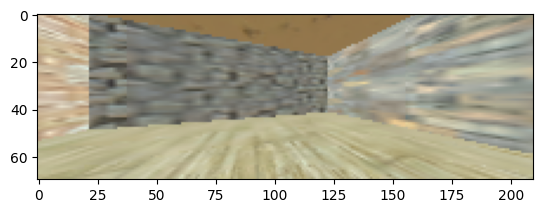

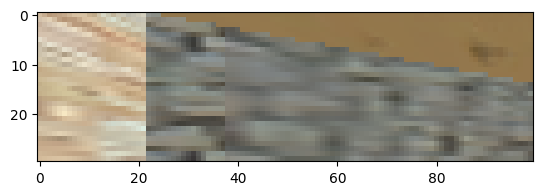

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(data[0]) # mitte unten ist immer bodentextur
plt.figure()
plt.imshow(data[0][:30,:100])

In [63]:
# images to video
import cv2
data_rgb = (data*255).astype(np.uint8)
height, width = data.shape[1:3]
fourcc = cv2.VideoWriter_fourcc(*'ffv1')
video = cv2.VideoWriter("coolVideo.mkv", fourcc, 5, (width,height))
for i,frame in enumerate(data_rgb):
    video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
video.release()

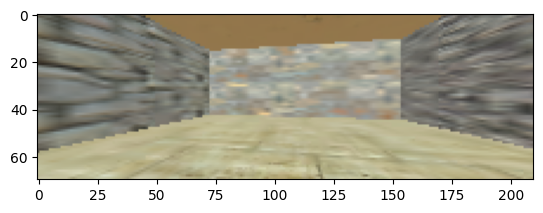

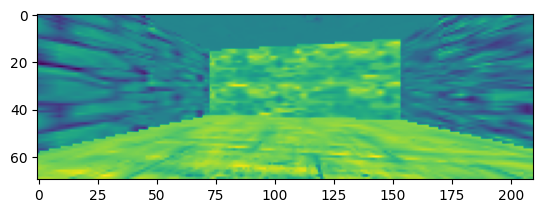

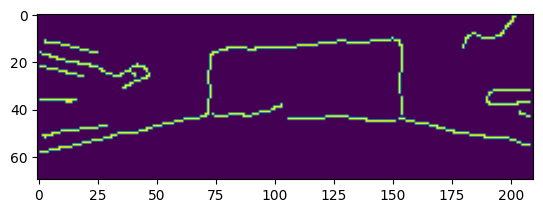

In [3]:
from skimage import feature
from skimage.color import rgb2gray
import cv2
edges = feature.canny(rgb2gray(data[1]), sigma=2.25)
plt.figure()
plt.imshow(data[1])
plt.figure()
plt.imshow(rgb2gray(data[1]))
plt.figure()
plt.imshow(edges)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
x_train, x_test = train_test_split(data, test_size=0.15, random_state=177013)
print(x_train.shape, x_test.shape)

(18700, 70, 210, 3) (3300, 70, 210, 3)


Model: "conv_lstm_autoencoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 3)              │       193,491 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,491 (755.82 KB)

 Trainable params: 193,491 (755.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
230/230 ━━━━━━━━━━━━━━━━━━━━ 61s 237ms/step - accuracy: 0.5690 - loss: 0.0194
Epoch 2/3
230/230 ━━━━━━━━━━━━━━━━━━━━ 57s 248ms/step - accuracy: 0.7634 - loss: 0.0115
Epoch 3/3
230/230 ━━━━━━━━━━━━━━━━━━━━ 61s 265ms/step - accuracy: 0.7720 - loss: 0.0105
Input shape: (7333, 1, 70, 210, 3)
Output shape: (1, 1, 70, 210, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Output values: [[[[[0.5600394  0.5362114  0.4931497 ]
    [0.5777212  0.554993   0.47802368]
    [0.58463675 0.5529575  0.4873199 ]
    ...
    [0.6404253  0.615179   0.5303142 ]
    [0.63691497 0.6160682  0.5284721 ]
    [0.59582496 0.5878841  0.50386465]]

   [[0.60591817 0.56177914 0.50938785]
    [0.6249775  0.5913958  0.5029036 ]
    [0.6265206  0.5936564  0.50486743]
    ...
    [0.7213544  0.6761021  0.5711151 ]
    [0.7186647  0.6798825  0.5685908 ]
    [0.6382588  0.6267579  0.53890884]]

   [[0.6164455  0.5824908  0.5244734 ]
    [0.641374   0.6107519  0.53177685]
    [0.64005363 0.60532373 0.5236344 ]
    ...
 

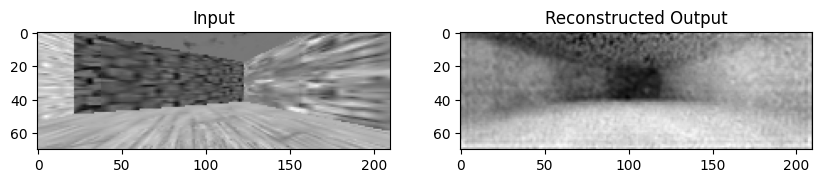

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input

class ConvLSTMAutoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(ConvLSTMAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.ConvLSTM2D(8, (3, 3), activation="relu", padding="same", return_sequences=True, input_shape=shape),
            layers.MaxPooling3D((1, 2, 2), padding="same"),
            layers.ConvLSTM2D(16, (3, 3), activation="relu", padding="same", return_sequences=False),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(np.prod((shape[0], shape[1]//2, shape[2]//2, 4)), activation='relu'),
            layers.Reshape((shape[0], shape[1]//2, shape[2]//2, 4)),
            layers.UpSampling3D((1, 2, 2)),
            layers.Conv3DTranspose(8, (3, 3, 3), activation='relu', padding="same"),
            layers.Conv3DTranspose(shape[3], (3, 3, 3), activation='sigmoid', padding="same")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Assuming x_train and x_test are your datasets with shape (num_samples, time_steps, height, width, channels)  # Example data with original dimensions
data_subset = data[:len(data)//3]  # Take only a tenth of the data
data_subset = np.expand_dims(data_subset, axis=1)
shape = data_subset.shape[1:]  # (time_steps, height, width, channels)
latent_dim = 3
autoencoder = ConvLSTMAutoencoder(latent_dim, shape)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["accuracy"])

# Print model summary
autoencoder.summary()

# Fit the model
history = autoencoder.fit(data_subset, data_subset, epochs=3, shuffle=True)

# Check input and output shapes
print("Input shape:", data_subset.shape)
sample_input = data_subset[2:3]  # Take one sample from the data
sample_output = autoencoder(sample_input)
print("Output shape:", sample_output.shape)

# Run a test prediction
sample_output = autoencoder.predict(sample_input)
print("Output values:", sample_output)

# Plotting the input and output
plt.figure(figsize=(10, 5))

# Plot the first frame of the input and output for comparison
plt.subplot(1, 2, 1)
plt.imshow(sample_input[0, 0, :, :, 0], cmap='gray')
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(sample_output[0, 0, :, :, 0], cmap='gray')
plt.title('Reconstructed Output')

plt.show()

In [33]:
from tensorflow.keras import layers, losses, Model, Input
# Create a model to get the encoder's output
input_layer = Input(shape=shape)
encoded_output = autoencoder.encoder(input_layer)
encoder_model = Model(inputs=input_layer, outputs=encoded_output)

In [25]:
i = 1
sample_input = data_subset[:i]
decoded = autoencoder(sample_input)
print(decoded)

tf.Tensor(
[[[[[0.5600394  0.5362114  0.4931497 ]
    [0.5777212  0.554993   0.47802368]
    [0.58463675 0.5529575  0.4873199 ]
    ...
    [0.6404253  0.615179   0.5303142 ]
    [0.63691497 0.6160682  0.5284721 ]
    [0.59582496 0.5878841  0.50386465]]

   [[0.60591817 0.56177914 0.50938785]
    [0.6249775  0.5913958  0.5029036 ]
    [0.6265206  0.5936564  0.50486743]
    ...
    [0.7213544  0.6761021  0.5711151 ]
    [0.7186647  0.6798825  0.5685908 ]
    [0.6382588  0.6267579  0.53890884]]

   [[0.6164455  0.5824908  0.5244734 ]
    [0.641374   0.6107519  0.53177685]
    [0.64005363 0.60532373 0.5236344 ]
    ...
    [0.72715837 0.68965316 0.58168805]
    [0.7245129  0.6981257  0.5864739 ]
    [0.65482426 0.6459126  0.56287247]]

   ...

   [[0.71091425 0.6441646  0.5547817 ]
    [0.7606416  0.71378744 0.5961315 ]
    [0.75901645 0.70709413 0.5799127 ]
    ...
    [0.7765401  0.73224527 0.5708108 ]
    [0.7690844  0.7291673  0.5698167 ]
    [0.6885383  0.681064   0.5637657 ]]

   [[

In [47]:
autoencoder.save("autoencoder.keras")

In [49]:
# images to video
import cv2
height, width = data.shape[1:3]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("coolVideo.mp4", fourcc, 5, (width,height))
font = cv2.QT_FONT_NORMAL
for i,frame in enumerate(data_subset[:300]):
    if i == 0:
        continue
    decode = autoencoder.predict(data_subset[i-1:i])
    encode = encoder_model.predict(data_subset[i-1:i])
    frame = decode.reshape(70,210,3)
    frame = (frame*255).astype(np.uint8)
    frame = cv2.cvtColor(frame.copy(), cv2.COLOR_RGB2BGR)
    if i%200==0:
        print(i)
    for val in range(3):
        cv2.putText(frame, f"{encode[0][val]}", (0,10*val+10), font, .5, (0,1,0),1,cv2.LINE_AA)
    video.write(frame)
video.release()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━

Input shape: (2200, 1, 70, 210, 3)
Output shape: (1, 1, 70, 210, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Output values: [[[[[0.5243608  0.508418   0.46585444]
    [0.5260569  0.5039969  0.45068502]
    [0.5220536  0.4992424  0.45052543]
    ...
    [0.5188389  0.4932605  0.4431818 ]
    [0.51861596 0.49710065 0.44992962]
    [0.5141629  0.5060929  0.46669912]]

   [[0.52908117 0.5215289  0.46329495]
    [0.53363305 0.5159632  0.4543556 ]
    [0.5260777  0.5103745  0.45134747]
    ...
    [0.5133732  0.49711418 0.43553042]
    [0.51758033 0.50142616 0.44066167]
    [0.5198716  0.50797313 0.46352944]]

   [[0.53042066 0.52642804 0.46898022]
    [0.5396005  0.52102655 0.46133092]
    [0.5290007  0.51377124 0.4576742 ]
    ...
    [0.51223594 0.497019   0.43819103]
    [0.5167111  0.5008677  0.44094294]
    [0.5212732  0.50305283 0.46560782]]

   ...

   [[0.62447804 0.60270005 0.5325662 ]
    [0.6654988  0.6394118  0.54757863]
    [0.6550069  0.6284588  0.53914255]
    ...
    [0.627067

Text(0.5, 1.0, 'Reconstructed Output')

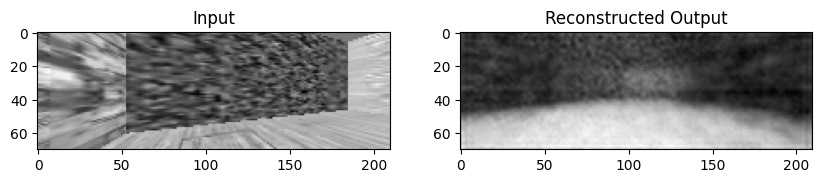

In [14]:
# Check input and output shapes
print("Input shape:", data_subset.shape)
sample_input = data_subset[1999:2000]  # Take one sample from the data
sample_output = autoencoder(sample_input)
print("Output shape:", sample_output.shape)

# Run a test prediction
sample_output = autoencoder.predict(sample_input)
print("Output values:", sample_output)

# Plotting the input and output
plt.figure(figsize=(10, 5))

# Plot the first frame of the input and output for comparison
plt.subplot(1, 2, 1)
plt.imshow(sample_input[0, 0, :, :, 0], cmap='gray')
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(sample_output[0, 0, :, :, 0], cmap='gray')
plt.title('Reconstructed Output')

In [9]:
autoencoder.summary()

Model: "conv_lstm_autoencoder_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 16)             │       570,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 10, 72, 216, 3) │     5,305,635 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,627,483 (67.24 MB)

 Trainable params: 5,875,827 (22.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,751,656 (44.83 MB)

In [14]:
# Training und Validation Accuracy aus history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

NameError: name 'history' is not defined

In [ ]:
encoded_imgs = autoencoder.encoder(data_subset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(data_subset[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
all_encode = encoder_model.predict(data_subset)
zoom = all_encode[:500]
gradient = np.linspace(0, 1, zoom.shape[0])
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter(zoom[:,0],zoom[:,1],zoom[:,2], cmap="viridis", c=gradient)
plt.show()

230/230 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

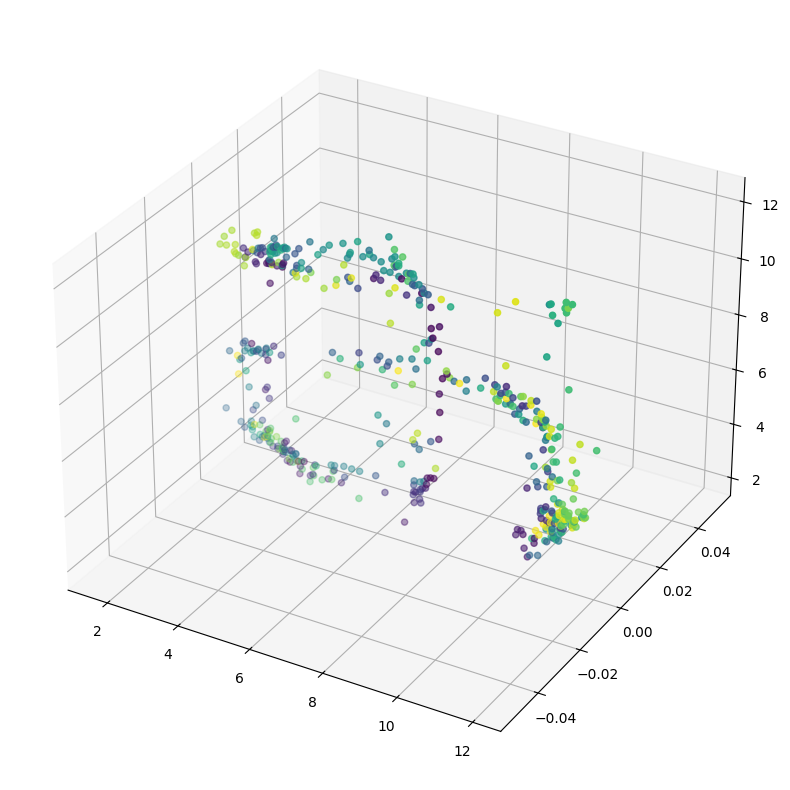

In [43]:
gradient = np.linspace(0, 1, zoom.shape[0])
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter(zoom[:,0],zoom[:,1],zoom[:,2], cmap="viridis", c=gradient)
plt.show()